# **目標一**:
### 使用 QNLI 資料集和 BERT-base-uncased 訓練 模型


# 安裝套件

In [1]:
pip install transformers datasets accelerate

# 確認 GPU 分配

In [2]:
!nvidia-smi

Wed Jan 26 06:02:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount 雲端硬碟

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 資料前處理

In [4]:
from datasets import load_dataset
import pandas as pd

datasets = load_dataset('glue', 'qnli')

train_data = pd.DataFrame(datasets['train']).drop(columns = ['idx'])
validation_data = pd.DataFrame(datasets['validation']).drop(columns = ['idx'])
# test_data = pd.DataFrame(datasets['test']).drop(columns = ['idx'])

print(datasets)

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})


In [5]:
print(train_data.info())
train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104743 entries, 0 to 104742
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  104743 non-null  object
 1   sentence  104743 non-null  object
 2   label     104743 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB
None


,question,sentence,label
0,When did the third Digimon series begin?,Unlike the two seasons before it and most of t...,1
1,Which missile batteries often have individual ...,"When MANPADS is operated by specialists, batte...",1
2,What two things does Popper argue Tarski's the...,He bases this interpretation on the fact that ...,0
3,What is the name of the village 9 miles north ...,"On 31 December 1853, the Ottoman forces at Cal...",0
4,What famous palace is located in London?,London contains four World Heritage Sites: the...,1
...,...,...,...
104738,What is Fairfield Court?,"Richmond's original street grid, laid out in 1...",1
104739,Who did William the Conqueror give the site of...,William gave the site to Geoffrey de Mandevill...,0
104740,What percentage of high-density penetrators is...,This ammunition consists of depleted uranium (...,0
104741,What individual was responsible for law and ma...,He was the top civil and military leader of th...,1


In [6]:
validation_data

,question,sentence,label
0,What came into force after the new constitutio...,"As of that day, the new constitution heralding...",0
1,What is the first major city in the stream of ...,The most important tributaries in this area ar...,1
2,What is the minimum required if you want to te...,In most provinces a second Bachelor's Degree s...,1
3,How was Temüjin kept imprisoned by the Tayichi...,The Tayichi'ud enslaved Temüjin (reportedly wi...,0
4,"What did Herr Gott, dich loben wir become know...","He paraphrased the Te Deum as ""Herr Gott, dich...",1
...,...,...,...
5458,How many people lived in Warsaw in 1939?,Unfortunately this belief still lives on in Po...,1
5459,One of FIS' agenda items was to force women to...,Taking advantage of economic failure and unpop...,0
5460,Dendritic cells are named that because they re...,Dendritic cells serve as a link between the bo...,1
5461,When did it retract to a inland formation?,"However, the rainforest still managed to thriv...",1


In [7]:
# test_data

In [8]:
print("entailment")
print(train_data['question'][2])
print(train_data['sentence'][2])
print(train_data['label'][2], '\n')

print("not_entailment")
print(train_data['question'][0])
print(train_data['sentence'][0])
print(train_data['label'][0], '\n')
# label = 0 entailment
# label = 1 not_entailment

print(type(train_data['question']))
print(type(train_data['sentence']))
print(type(train_data['label']))

entailment
What two things does Popper argue Tarski's theory involves in an evaluation of truth?
He bases this interpretation on the fact that examples such as the one described above refer to two things: assertions and the facts to which they refer.
0 

not_entailment
When did the third Digimon series begin?
Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese.
1 

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [9]:
train_question, train_sentence, train_label = train_data['question'][0:20000].tolist(), train_data['sentence'][0:20000].tolist(), train_data['label'][0:20000].tolist()
eval_question, eval_sentence, eval_label = validation_data['question'][0:2000].tolist(), validation_data['sentence'][0:2000].tolist(), validation_data['label'][0:2000].tolist()
# 將dataframe格式轉成list(tokenize時使用)

print(len(train_question))
print(type(train_question))

20000
<class 'list'>


In [10]:
print(set(eval_label))

{0, 1}


# 將資料進行 Tokenize
## 將 input 資料轉換成 token id 、tpye_id 與 attention_mask

In [11]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_question, train_sentence, padding='max_length', truncation=True, max_length=256)
eval_encodings = tokenizer(eval_question, eval_sentence, padding='max_length', truncation=True, max_length=256)

# max_length 參考:
# https://huggingface.co/docs/transformers/preprocessing
# https://blog.csdn.net/qq_33293040/article/details/105439750
# https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt

In [12]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [13]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
print("input_ids\n", train_encodings['input_ids'][0])
print("input_ids_decode\n", tokenizer.decode(train_encodings['input_ids'][0]))
print("token_type_ids\n", train_encodings['token_type_ids'][0])
print("attention_mask\n", train_encodings['attention_mask'][0])

print(type(train_encodings))

input_ids
 [101, 2043, 2106, 1996, 2353, 10667, 16339, 2078, 2186, 4088, 1029, 102, 4406, 1996, 2048, 3692, 2077, 2009, 1998, 2087, 1997, 1996, 3692, 2008, 2628, 1010, 10667, 16339, 2078, 24763, 2869, 3138, 1037, 9904, 1998, 2062, 12689, 3921, 2000, 2049, 2466, 3794, 10667, 16339, 2078, 2040, 2079, 2025, 27788, 10010, 12556, 2044, 2037, 6677, 1998, 2062, 3375, 2839, 2458, 1999, 1996, 2434, 2887, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_ids_decode


In [15]:
print(len(train_encodings['input_ids'][0]))
print(len(train_encodings['token_type_ids'][0]))

256
256


## 加入 Label

In [16]:
def add_targets(encodings, label):
  encodings.update({'label': label})

add_targets(train_encodings, train_label)
add_targets(eval_encodings, eval_label)

print(train_encodings.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label'])


In [17]:
print(train_encodings['input_ids'][0])
print(train_encodings['token_type_ids'][0])
print(train_encodings['attention_mask'][0])
print(train_encodings['label'][0])

[101, 2043, 2106, 1996, 2353, 10667, 16339, 2078, 2186, 4088, 1029, 102, 4406, 1996, 2048, 3692, 2077, 2009, 1998, 2087, 1997, 1996, 3692, 2008, 2628, 1010, 10667, 16339, 2078, 24763, 2869, 3138, 1037, 9904, 1998, 2062, 12689, 3921, 2000, 2049, 2466, 3794, 10667, 16339, 2078, 2040, 2079, 2025, 27788, 10010, 12556, 2044, 2037, 6677, 1998, 2062, 3375, 2839, 2458, 1999, 1996, 2434, 2887, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 

# 定義 Dataset，並轉換成 tensor 格式

In [18]:
from torch.utils import data
import torch

class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

train_dataset = Dataset(train_encodings)
eval_dataset = Dataset(eval_encodings)

In [19]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  2043,  2106,  1996,  2353, 10667, 16339,  2078,  2186,  4088,
          1029,   102

# 載入模型架構( SequenceClassification )

In [20]:
from transformers import BertConfig, BertForSequenceClassification
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)  #num_labels 設定類別數
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 查看模型架構

In [21]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# 訓練模型

In [22]:
import logging
import datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import math

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    default_data_collator,
    get_scheduler
)

## 設定 epoch 與 batch size

In [23]:
train_batch_size = 8      # 設定 training batch size
eval_batch_size = 10      # 設定 eval batch size
num_train_epochs = 3      # 設定 epoch

## 將資料丟入 DataLoader


In [24]:
data_collator = default_data_collator
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=train_batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

## Optimizer 、Learning rate 、Scheduler 設定

In [25]:
learning_rate=3e-5          # 設定 learning_rate
gradient_accumulation_steps = 1   # 設定 幾步後進行反向傳播

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },                                
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
max_train_steps = num_train_epochs * num_update_steps_per_epoch
print('max_train_steps', max_train_steps)

# scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

max_train_steps 7500


## 將資料、參數丟入 Accelerator



In [26]:
# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [27]:
eval_dataloader

## 設定 metric 方法

In [28]:
# Get the metric function

metric = load_metric("accuracy")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

## 開始訓練

In [29]:
# # Train!
# logger = logging.getLogger(__name__)
# logging.basicConfig(
#     format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
#     datefmt="%m/%d/%Y %H:%M:%S",
#     level=logging.INFO,
# )
# logger.info(accelerator.state)
# output_dir = '/content/drive/Shareddrives/中興大學/晨華偷用中/QNLI'  # your folder


# total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

# logger.info("***** Running training *****")
# logger.info(f"  Num examples = {len(train_dataset)}")
# logger.info(f"  Num Epochs = {num_train_epochs}")
# logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
# logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
# logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
# logger.info(f"  Total optimization steps = {max_train_steps}")


# completed_steps = 0
# best_epoch = {"epoch": 0, "acc": 0 }

# for epoch in trange(num_train_epochs, desc="Epoch"):
#   model.train()
#   for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
#     outputs = model(**batch)
#     loss = outputs.loss
#     loss = loss / gradient_accumulation_steps
#     accelerator.backward(loss)
#     if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
#       optimizer.step()
#       lr_scheduler.step()
#       optimizer.zero_grad()
#       completed_steps += 1

#     if step % 50 == 0:
#       print({'epoch': epoch, 'step': step, 'loss': loss.item()})

#     if completed_steps >= max_train_steps:
#       break
      
#   logger.info("***** Running eval *****")
#   model.eval()
#   for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
#     outputs = model(**batch)
#     predictions = outputs.logits.argmax(dim=-1)
#     metric.add_batch(
#         predictions=accelerator.gather(predictions),
#         references=accelerator.gather(batch["labels"]),
#     )

#   eval_metric = metric.compute()
#   logger.info(f"epoch {epoch}: {eval_metric}")
#   if eval_metric['accuracy'] > best_epoch['acc']:
#     best_epoch.update({"epoch": epoch, "acc": eval_metric['accuracy']})
#     # best_epoch['epoch'] = epoch
#     # best_epoch['acc'] = eval_metric['accuracy']

#   if output_dir is not None:
#     accelerator.wait_for_everyone()
#     unwrapped_model = accelerator.unwrap_model(model)
#     unwrapped_model.save_pretrained(output_dir + '/' + 'epoch_' + str(epoch), save_function=accelerator.save)

In [30]:
print(best_epoch)

NameError: ignored

# 分析模型

In [31]:
# **計算 Precision, Recall, F1-score **
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification, default_data_collator
from torch.utils.data import DataLoader
from accelerate import Accelerator
from tqdm.auto import tqdm

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
%cd /content/drive/Shareddrives/中興大學/晨華偷用中/"QNLI"

/content/drive/Shareddrives/中興大學/晨華偷用中/QNLI


In [34]:
! ls

epoch_0  epoch_1  Epoch_1  epoch_2


# 載入模型

In [35]:
# Epoch_1 acc = 0.876, mathew = 0.75
# epoch_2 acc = 0.8375, mathew = 0.679
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained("./Epoch_1/config.json") 
model = BertForSequenceClassification.from_pretrained("./Epoch_1/pytorch_model.bin", config = config)

In [36]:
eval_questions, eval_sentences, eval_labels = validation_data['question'][0:2500].tolist(), validation_data['sentence'][0:2500].tolist(), validation_data['label'][0:2500].tolist()

eval_encodings = tokenizer(eval_questions, eval_sentences, truncation=True, padding=True)
add_targets(eval_encodings, eval_labels)

eval_dataset = Dataset(eval_encodings)

In [37]:
eval_batch_size = 10      # 設定 batch size
data_collator = default_data_collator

eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, eval_dataloader = accelerator.prepare(
    model, eval_dataloader
)

In [38]:
print("***** Running eval *****")
model.eval()

labels = []
predictions = []

for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
  outputs = model(**batch)
  predicted = outputs.logits.argmax(dim=-1)

  labels += batch["labels"].tolist()
  predictions += predicted.tolist()


***** Running eval *****


Eval Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

In [39]:
import datasets
datasets.list_metrics()

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'f1',
 'gleu',
 'glue',
 'google_bleu',
 'indic_glue',
 'matthews_correlation',
 'mauve',
 'meteor',
 'pearsonr',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli']

In [40]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")
accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print(accuracy)

{'accuracy': 0.8752}


In [41]:
from sklearn.metrics import classification_report

for line in classification_report(labels, predictions).split('\n'):
  print(line)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1229
           1       0.89      0.87      0.88      1271

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



# confusion_matrix

In [42]:
# **產生 confusion matrix heatmap **
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [43]:
cf_matrix = confusion_matrix(labels, predictions)
print(cf_matrix)

[[1086  143]
 [ 169 1102]]


In [44]:
matthews = matthews_corrcoef(labels, predictions)
print(matthews)

0.7505791330117884


# heatmap

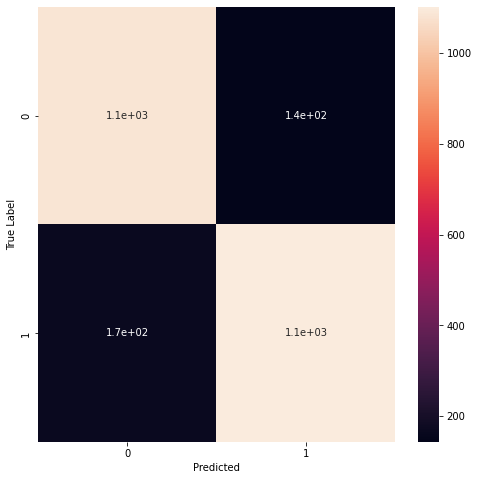

In [45]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

col = [ i for i in range(0,2)] #類別名稱

df_cm = pd.DataFrame(cf_matrix, columns=col, index = col)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)

# Inference

In [46]:
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification

In [57]:
# **撰寫預測程式**
def QNLI_model(model, question, sentence):
  input_encodings = tokenizer([question], [sentence], padding='max_length', truncation=True, max_length=256)
  input_dataset = Dataset(input_encodings)

  data_collator = default_data_collator
  input_dataloader = DataLoader(input_dataset, collate_fn=data_collator, batch_size=1)  

  accelerator = Accelerator()
  model, input_dataloader = accelerator.prepare(model, input_dataloader)

  for batch in input_dataloader:
    outputs = model(**batch)
    predicted = outputs.logits.argmax(dim=-1)
  return predicted

In [54]:
print(validation_data['question'][88])
print(validation_data['sentence'][88])
print(validation_data['label'][88])

print(validation_data['question'][888])
print(validation_data['sentence'][888])
print(validation_data['label'][888])

What was the Marburg Colloquy meant to establish?
Agreement was achieved on fourteen points out of fifteen, the exception being the nature of the Eucharist – the sacrament of the Lord's Supper—an issue crucial to Luther.
1
According to the humoral theory of immunity, what were the bodies immune agents?
In contrast, the humoral theory of immunity, held, among others, by Robert Koch and Emil von Behring, stated that the active immune agents were soluble components (molecules) found in the organism’s “humors” rather than its cells.
0


In [61]:
question = eval_question[888]# "who is the author of harry potter?"
sentence = eval_sentence[888]# "Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling."

predict = QNLI_model(model, question, sentence)
print("question : ", question)
print("answer : ", sentence)
print("true_label : ", eval_label[888], "\n")

print("predict_label : ", predict.item())
if predict.item():
  print("not_entailmenat")
else:
  print("entailment")

question :  According to the humoral theory of immunity, what were the bodies immune agents?
answer :  In contrast, the humoral theory of immunity, held, among others, by Robert Koch and Emil von Behring, stated that the active immune agents were soluble components (molecules) found in the organism’s “humors” rather than its cells.
true_label :  0 

predict_label :  0
entailment
